## import libararies



In [1]:
import openeo
from pathlib import Path
import config as config
print(config.CLASS_MAPPING)


{0: 'Background', 1: 'Other Large Scale Cropland', 2: 'Pasture', 3: 'Mining', 4: 'Other Small Scale Cropland', 5: 'Roads', 6: 'Forest', 7: 'Plantation Forest', 8: 'Coffee', 9: 'Built up', 10: 'Water', 11: 'Oil Palm', 12: 'Rubber', 13: 'Cacao', 14: 'Avocado', 15: 'Soy', 16: 'Sugar', 17: 'Maize', 18: 'Banana', 19: 'Pineapple', 20: 'Rice', 21: 'Wood Logging', 22: 'Cashew', 23: 'Tea'}


## Main Code for creating the workflow

In [ ]:
from geospatial_pipeline.input_cube_loader import load_input_cube
from geospatial_pipeline.band_normalization import normalize_cube
from geospatial_pipeline.onnx_inference import run_inference


connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()


cube = load_input_cube(
        connection,
        spatial_extent=config.SPATIAL_EXTENT,
        temporal_extent=config.TEMPORAL_EXTENT,
        max_cloud_cover=config.MAX_CLOUD_COVER,
        resolution=config.RESOLUTION,
        crs=config.CRS
    )

cube_normalised = normalize_cube(cube)

# Run inference
inference_cube = run_inference(
    cube_normalised,
    model_name=config.MODEL_NAME,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE
)

class_labels = [config.CLASS_MAPPING[i] for i in sorted(config.CLASS_MAPPING)] + ["ARGMAX"]
inference_cube = inference_cube.rename_labels(dimension='bands', target=class_labels)

save_inference_cube = inference_cube.save_result(format = "netCDF")
save_inference_cube


Authenticated using refresh token.


## Execute

In [6]:
job = connection.create_job(save_inference_cube,
    additional=config.JOB_OPTIONS
)
job.start_and_wait()

0:00:00 Job 'j-250912101403408f8ab5d1ef8b2ef05f': send 'start'
0:00:17 Job 'j-250912101403408f8ab5d1ef8b2ef05f': created (progress 0%)
0:00:22 Job 'j-250912101403408f8ab5d1ef8b2ef05f': created (progress 0%)
0:00:29 Job 'j-250912101403408f8ab5d1ef8b2ef05f': created (progress 0%)
0:00:36 Job 'j-250912101403408f8ab5d1ef8b2ef05f': created (progress 0%)
0:00:46 Job 'j-250912101403408f8ab5d1ef8b2ef05f': created (progress 0%)
0:00:59 Job 'j-250912101403408f8ab5d1ef8b2ef05f': created (progress 0%)
0:01:14 Job 'j-250912101403408f8ab5d1ef8b2ef05f': running (progress N/A)
0:01:34 Job 'j-250912101403408f8ab5d1ef8b2ef05f': running (progress N/A)
0:02:00 Job 'j-250912101403408f8ab5d1ef8b2ef05f': running (progress N/A)
0:02:30 Job 'j-250912101403408f8ab5d1ef8b2ef05f': running (progress N/A)
0:03:08 Job 'j-250912101403408f8ab5d1ef8b2ef05f': running (progress N/A)
0:03:54 Job 'j-250912101403408f8ab5d1ef8b2ef05f': running (progress N/A)
0:04:55 Job 'j-250912101403408f8ab5d1ef8b2ef05f': running (progress

<BatchJob job_id='j-250912101403408f8ab5d1ef8b2ef05f'>

In [2]:
import xarray as xr
import openeo

connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

output_dir = "C:\\Git_projects\\WAC\\classification\\test\\" + job.job_id
path = job.get_results().download_files(f"{output_dir}")
ds = xr.open_dataset(path[0])
ds


Authenticated using refresh token.


NameError: name 'job' is not defined

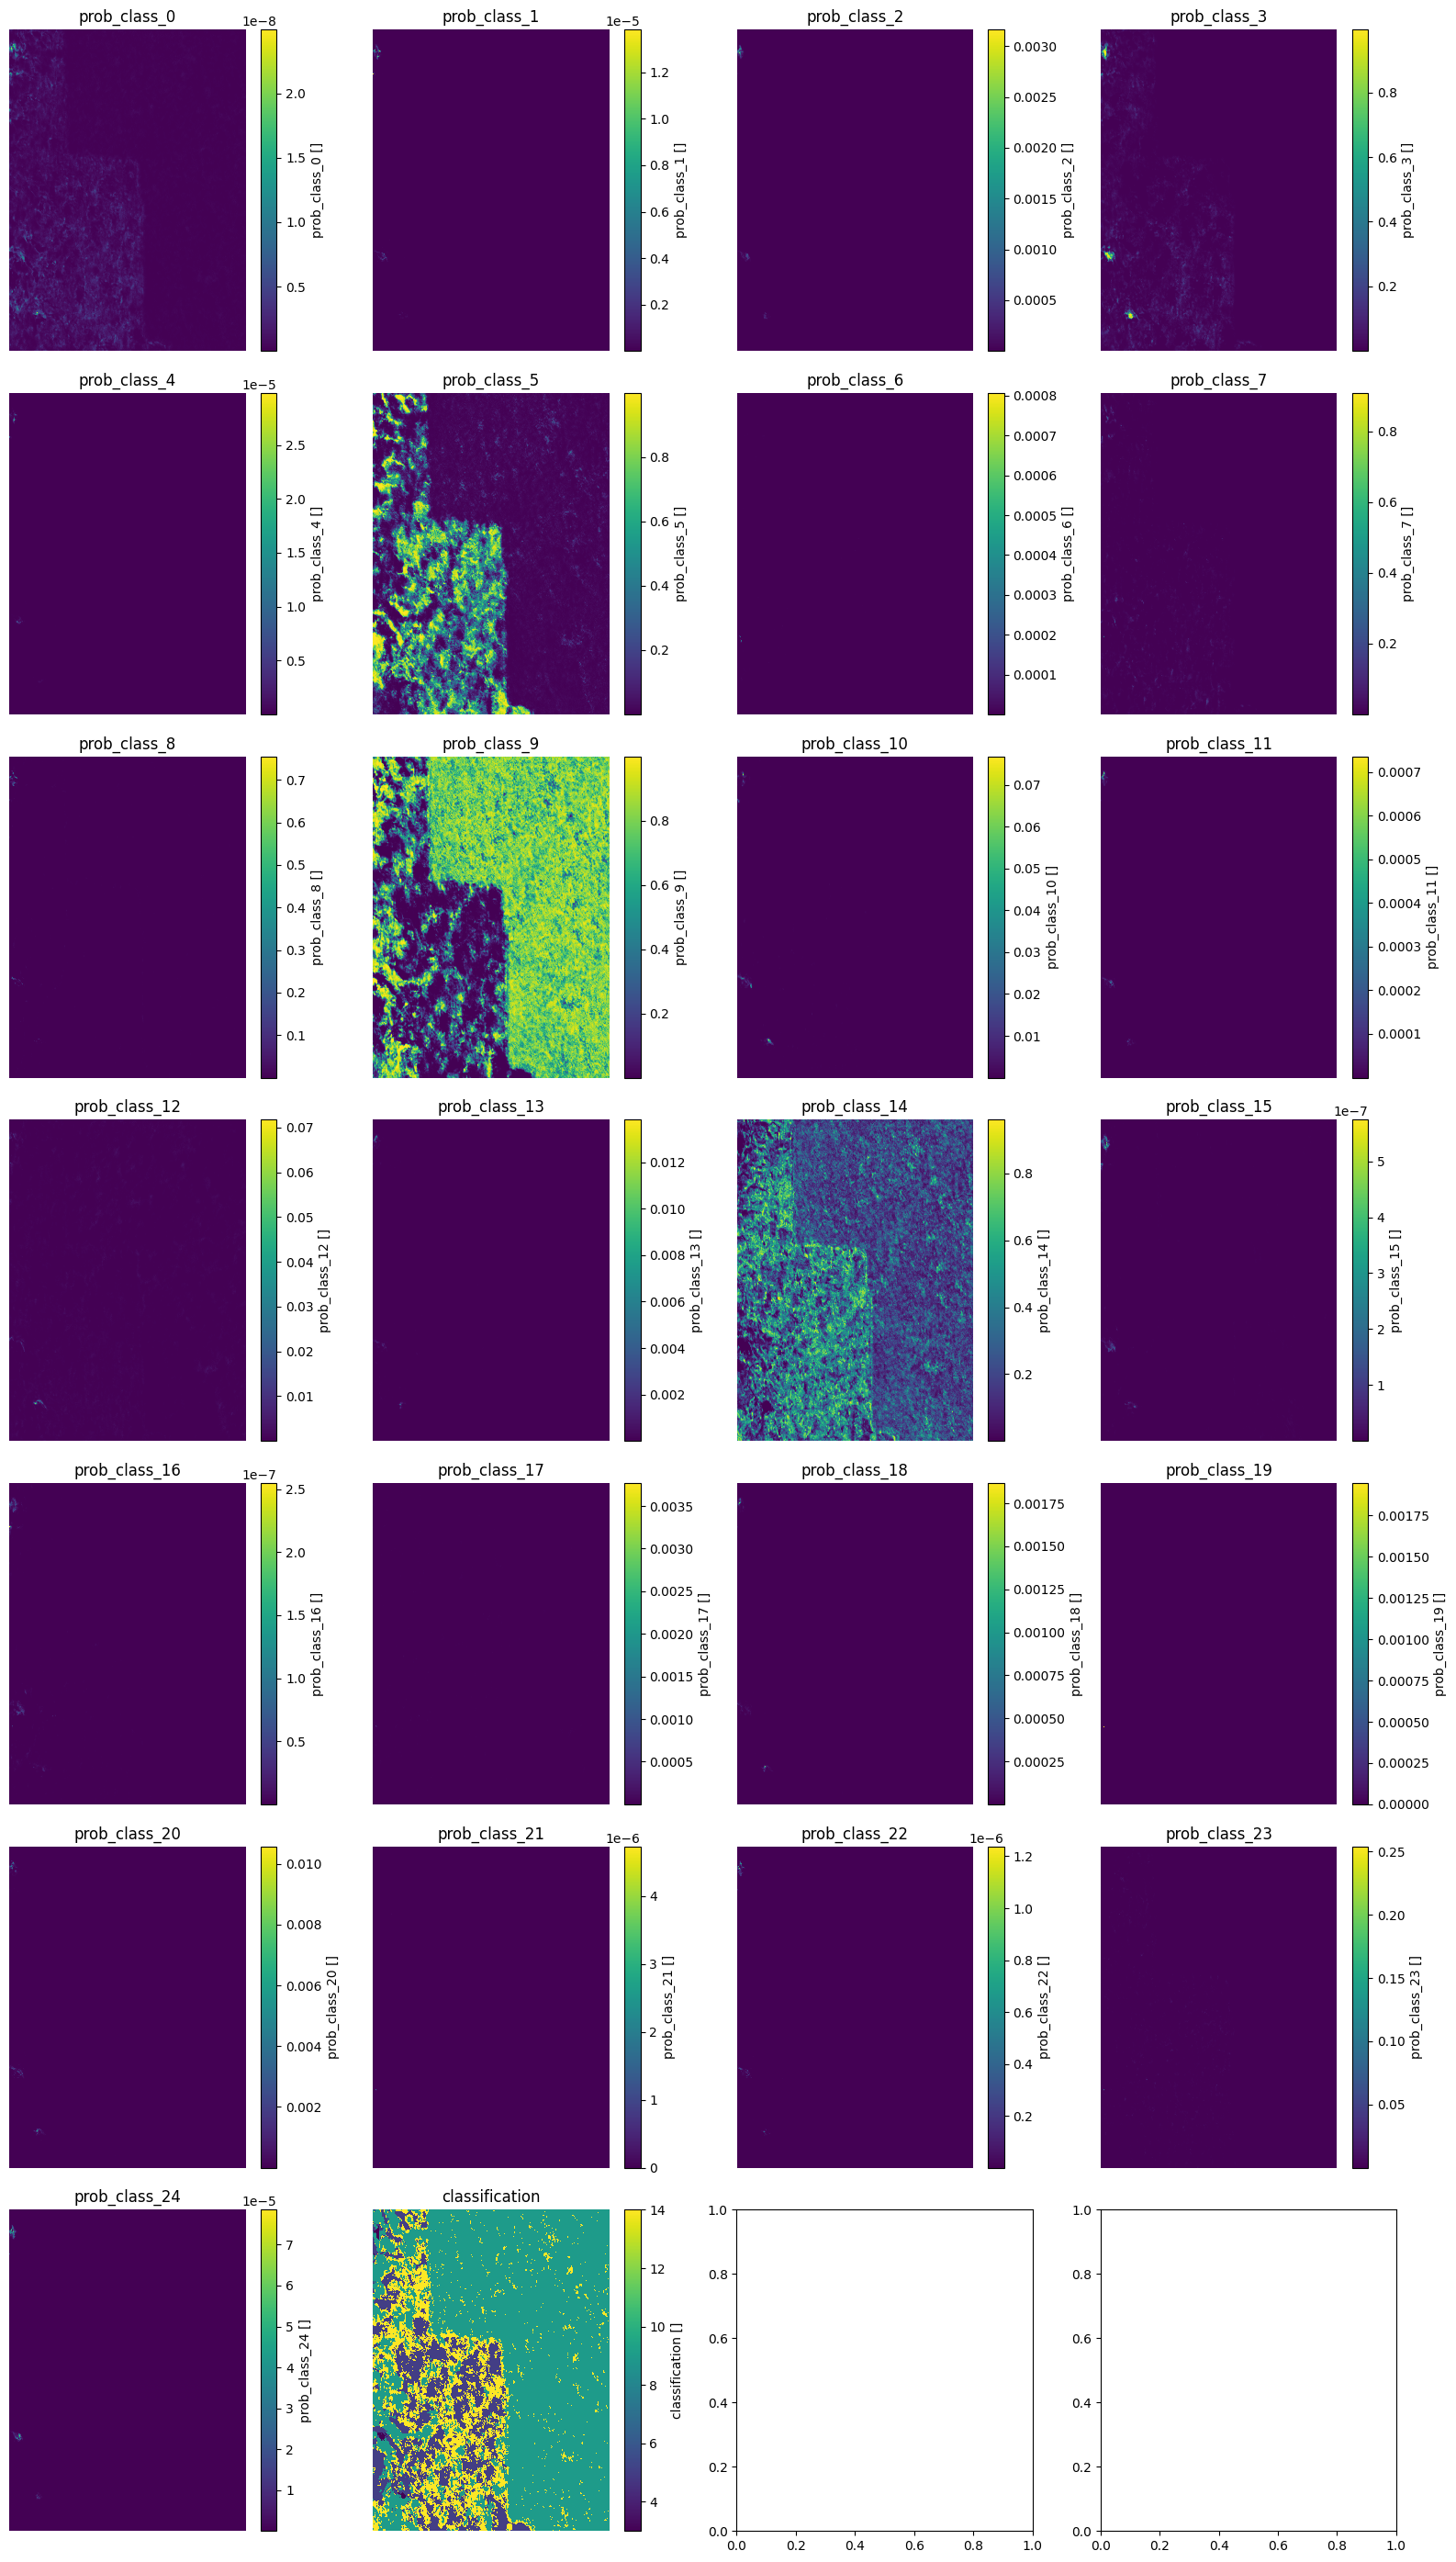

In [3]:
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr

time_step = 0
# Load dataset


ds = xr.open_dataset("C:\\Git_projects\\WAC\\classification\\WAC_LL2_CocoaTestSite4_Demo\\j-2509041435524157a357796ce56a9cae\\openEO.nc")

# Filter only variables with dimensions (t, y, x)
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

n = len(variables_to_plot)
ncols = 4  # adjust based on how wide you want the figure
nrows = -(-n // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

# Loop through variables and plot with fixed color scale
for i, var in enumerate(variables_to_plot):
    data = ds[var].isel(t=time_step)

    ax = axes.flat[i]
    im = data.plot(ax=ax, add_colorbar=True)  # no individual colorbar
    ax.set_title(var)
    ax.axis('off')

plt.tight_layout()
plt.show()